In [1]:
import pandas as pd

FILENAME = 'metrics_comparison_test.csv'


def print_df(df):
    # 'display.max_rows', None,
    with pd.option_context('display.max_columns', None, 'display.expand_frame_repr', False):
        print(df)


def get_metrics_df(filename):
    df = pd.read_csv(
        filename,
        sep=';',
        header=1,
        # index_col=0,
    )
    df.rename(columns={'Unnamed: 0': 'metrics'}, inplace=True)
    df.drop(columns=['optimal', 'miserable'], inplace=True)
    # df.drop(index=df[df.metrics == 'SMAPE'].index, inplace=True)
    return df


df = get_metrics_df(FILENAME)
print_df(df)

             metrics   hgbr linreg     nn     gp   mvnn  qhgbr     qr cp_hgbr cp_linreg  cp_nn  la_nn
0                MAE  137,0  212,3  152,5  135,7  153,0  146,0  144,5   137,0     212,3  152,5  152,5
1               RMSE  182,2  283,4  197,2  179,5  197,5  193,4  188,0   182,2     283,4  197,2  197,2
2       SMAPE (x100)   1,07   1,68   1,19   1,04   1,20   1,13   1,12    1,07      1,68   1,19   1,19
3               CRPS    NaN    NaN    NaN   96,3  111,2   95,1  103,5    99,2     152,8  108,4  108,2
4            PINBALL    NaN    NaN    NaN   49,0   56,4   52,3   52,7    50,4      78,0   55,2   55,1
5                NLL    NaN    NaN    NaN   6,60   6,97   6,66   6,69    6,68      7,07   6,71   6,70
6                SSR    NaN    NaN    NaN   0,88   0,68   0,82   0,93    0,80      1,05   0,90   0,97
7     ABS MISCOV (%)    NaN    NaN    NaN    3,3   12,4    6,8    5,3     5,0       1,8    2,9    1,2
8  ABS MISCALIBR (%)    NaN    NaN    NaN    6,3   13,6    3,9    5,1     3,2     

In [2]:
df2 = df.copy()
df2.index = df2.metrics
df2.drop(columns=['metrics'], inplace=True)
df2.rename(index={'SMAPE (x100)': 'SMAPE_SCALED', 'ABS MISCOV (%)': 'ABS_MISCOV', 'ABS MISCALIBR (%)': 'ABS_MISCALIBR'}, inplace=True)
df2.replace(r'(\d+),(\d+)', r'\1.\2', regex=True, inplace=True)  # convert to floats
df2 = df2.astype(float)
df2

,hgbr,linreg,nn,gp,mvnn,qhgbr,qr,cp_hgbr,cp_linreg,cp_nn,la_nn
metrics,,,,,,,,,,,
MAE,137.00,212.30,152.50,135.70,153.00,146.00,144.50,137.00,212.30,152.50,152.50
RMSE,182.20,283.40,197.20,179.50,197.50,193.40,188.00,182.20,283.40,197.20,197.20
SMAPE_SCALED,1.07,1.68,1.19,1.04,1.20,1.13,1.12,1.07,1.68,1.19,1.19
CRPS,NaN,NaN,NaN,96.30,111.20,95.10,103.50,99.20,152.80,108.40,108.20
PINBALL,NaN,NaN,NaN,49.00,56.40,52.30,52.70,50.40,78.00,55.20,55.10
NLL,NaN,NaN,NaN,6.60,6.97,6.66,6.69,6.68,7.07,6.71,6.70
SSR,NaN,NaN,NaN,0.88,0.68,0.82,0.93,0.80,1.05,0.90,0.97
ABS_MISCOV,NaN,NaN,NaN,3.30,12.40,6.80,5.30,5.00,1.80,2.90,1.20
ABS_MISCALIBR,NaN,NaN,NaN,6.30,13.60,3.90,5.10,3.20,3.80,5.70,5.50


In [3]:
# compute metrics means by group
import numpy as np

INCLUDE_BASELINES = False

METRICS_DICT = {
    'deterministic': ['MAE', 'RMSE', 'SMAPE_SCALED'],
    'probabilistic': ['NLL', 'CRPS', 'PINBALL', 'SSR', 'ABS_MISCOV', 'ABS_MISCALIBR'],
}
MODELS_DICT = {
    'base': ['linreg', 'hgbr', 'nn'],
    'posthoc': ['cp_linreg', 'cp_hgbr', 'cp_nn', 'la_nn'],
    'native': ['qr', 'qhgbr', 'mvnn', 'gp']
}


def get_metric_value(df, metric, method):
    return df.loc[metric][method]


if not INCLUDE_BASELINES:
    MODELS_DICT['base'].remove('linreg')    
    MODELS_DICT['posthoc'].remove('cp_linreg')
    MODELS_DICT['native'].remove('qr')


METRICS_MEANS_BY_METHOD_TYPE = {'posthoc': {}, 'native': {}}
for metrics_type, metrics in METRICS_DICT.items():
    for metric in metrics:
        for method_type, metrics_means_dict in METRICS_MEANS_BY_METHOD_TYPE.items():
            if method_type == 'native' or metrics_type == 'probabilistic':
                models_key = method_type
            else:
                models_key = 'base'  # avoid double-counting NNs
            method_type_metrics_values = [get_metric_value(df2, metric, method)
                                          for method in MODELS_DICT[models_key]]
            metrics_means_dict[metric] = np.mean(method_type_metrics_values)
METRICS_MEANS_BY_METHOD_TYPE

{'posthoc': {'MAE': 144.75,
  'RMSE': 189.7,
  'SMAPE_SCALED': 1.13,
  'NLL': 6.696666666666666,
  'CRPS': 105.26666666666667,
  'PINBALL': 53.56666666666666,
  'SSR': 0.89,
  'ABS_MISCOV': 3.033333333333333,
  'ABS_MISCALIBR': 4.8},
 'native': {'MAE': 144.9,
  'RMSE': 190.13333333333333,
  'SMAPE_SCALED': 1.1233333333333333,
  'NLL': 6.743333333333332,
  'CRPS': 100.86666666666667,
  'PINBALL': 52.56666666666666,
  'SSR': 0.7933333333333333,
  'ABS_MISCOV': 7.5,
  'ABS_MISCALIBR': 7.933333333333334}}

deterministic
saving
showing


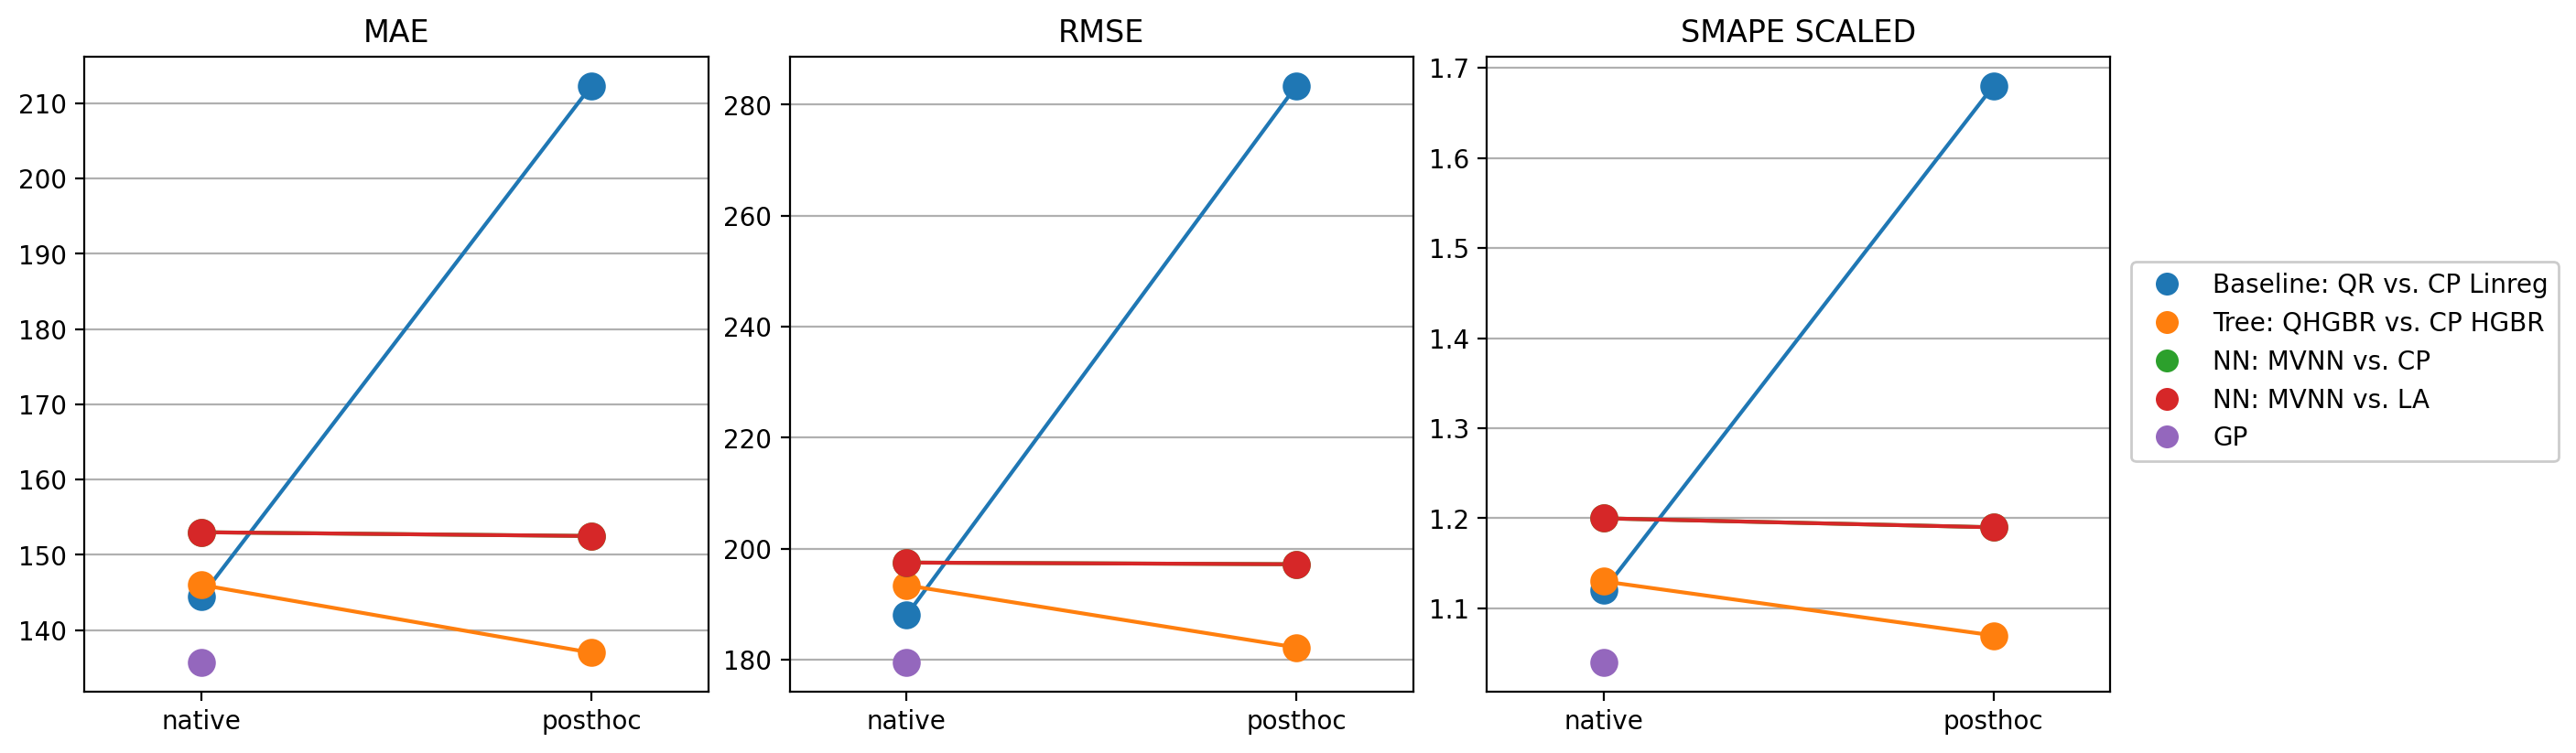

probabilistic
saving
showing


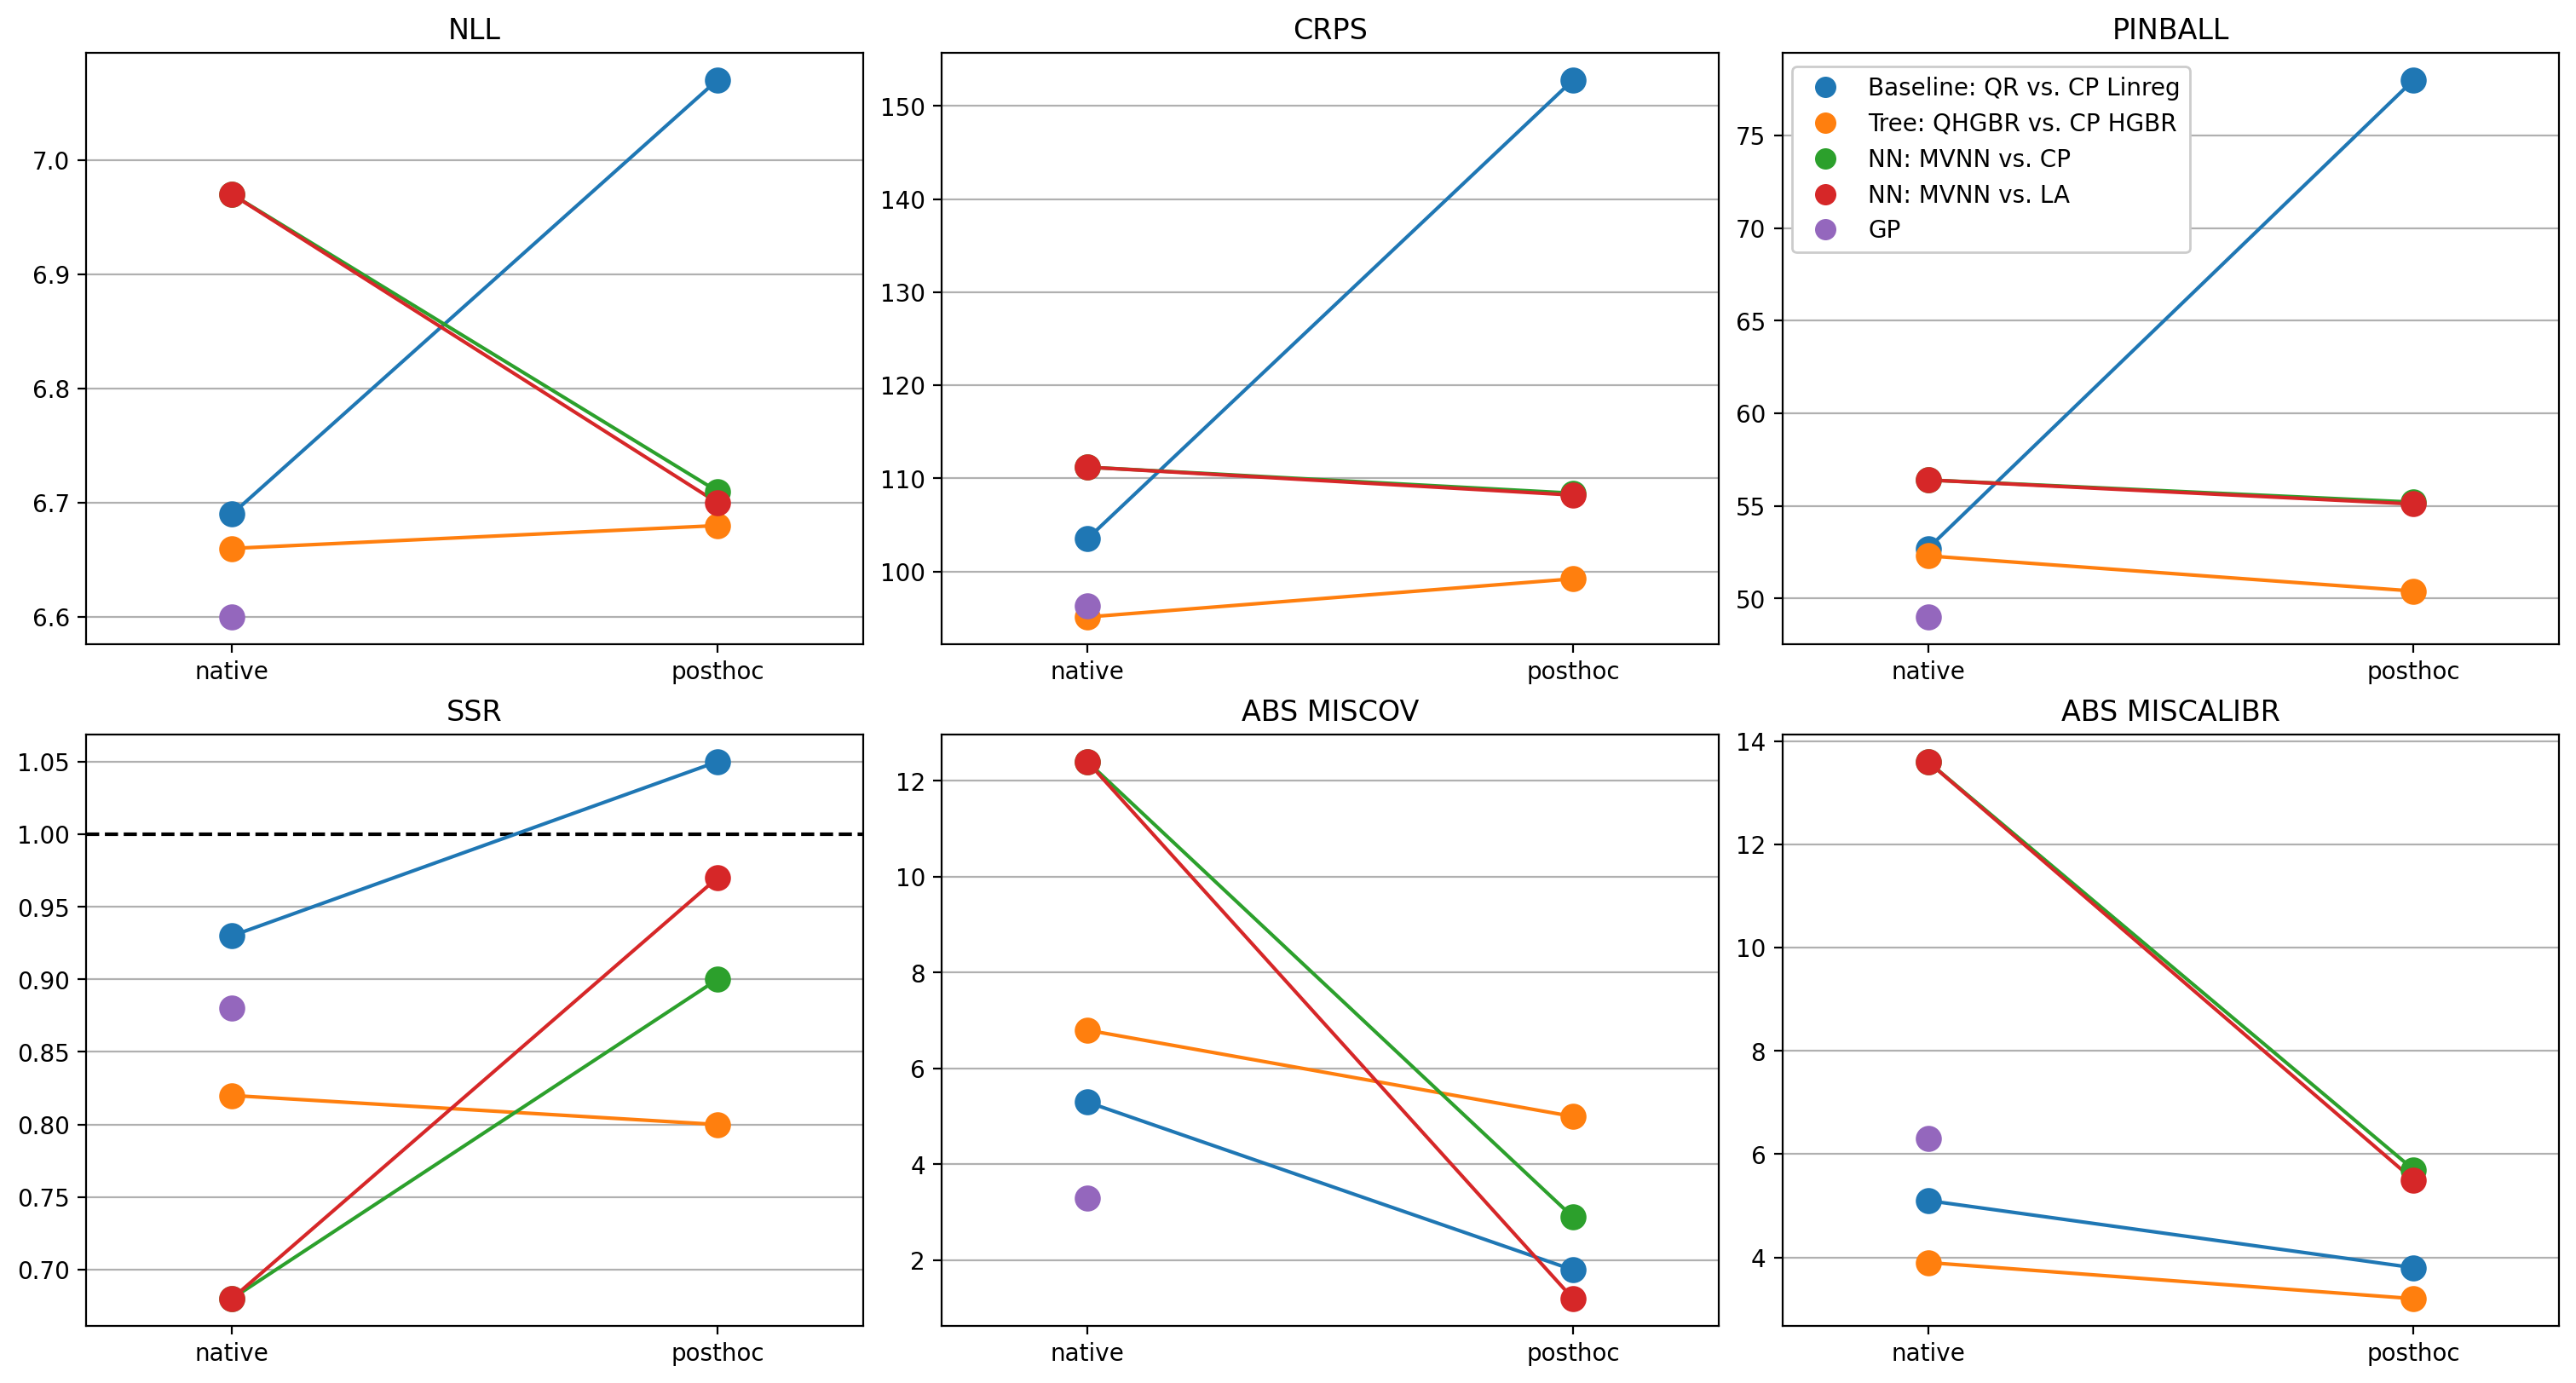

In [17]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

SCATTER_SIZE = 10 **2
SCATTER_ALPHA = 1
DPI = 200
SAVE_FIG = True
FIGURE_FOLDER = 'comparison_storage/plots/'
FIGURE_FILENAMES = {'deterministic': 'metrics_lineplot_det.pdf', 'probabilistic': 'metrics_lineplot_prob.pdf'}
PLOT_MEANS = False


TYPE_TO_METHOD_PAIRS = {
    'Baseline: QR vs. CP Linreg': ['qr', 'cp_linreg'],
    'Tree: QHGBR vs. CP HGBR': ['qhgbr', 'cp_hgbr'],
    'NN: MVNN vs. CP': ['mvnn', 'cp_nn'],
    'NN: MVNN vs. LA': ['mvnn', 'la_nn'],
    'GP': ['gp', None],
}
METRICS_DICT = {
    'deterministic': ['MAE', 'RMSE', 'SMAPE_SCALED'],
    'probabilistic': ['NLL', 'CRPS', 'PINBALL', 'SSR', 'ABS_MISCOV', 'ABS_MISCALIBR'],
}
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

MEANS_LABEL = 'means' if INCLUDE_BASELINES else 'means (no baselines)'


def plot_metrics_pairs(df, metric, type_to_method_pairs, ax=None, scatter_alpha=0.9, scatter_size=10**2, x_shift=0.3):  #, show=True):
    x_plot = [0, 1]
    if ax is None:
        fig, ax = plt.subplots()
    method_types = ['native', 'posthoc']

    zorder_lines = 4
    zorder_scatter = 5
    zorder_grid = -1
    zorder_axhline = 2


    ax.grid(axis='y', zorder=zorder_grid)
    
    if metric == 'SSR':
        ax.axhline(1, color='white', linestyle='-', linewidth=3, zorder=zorder_axhline)  # draw over grid
        ax.axhline(1, color='black', linestyle='--', linewidth=1.5, zorder=zorder_axhline)
    
    if PLOT_MEANS:
        # plot means
        metrics_means = [METRICS_MEANS_BY_METHOD_TYPE[method_type][metric] for method_type in method_types]
        ax.plot(x_plot, metrics_means, color='black', zorder=zorder_lines)
        ax.scatter(x_plot, metrics_means, label=MEANS_LABEL, color='black', s=scatter_size, alpha=scatter_alpha, zorder=zorder_scatter)

    # plot method pairs
    for (method_type, pair), color in zip(type_to_method_pairs.items(), COLORS):
        method1, method2 = pair
        if method2 is None:
            metric_value1 = get_metric_value(df, metric, method1)
            ax.scatter(x_plot[:1], metric_value1, label=method_type, color=color, s=scatter_size, alpha=scatter_alpha, zorder=zorder_scatter)
            continue
        metrics_values = [get_metric_value(df, metric, method) for method in pair]
        ax.plot(x_plot, metrics_values, color=color, zorder=zorder_lines)
        ax.scatter(x_plot, metrics_values, label=method_type, color=color, s=scatter_size, alpha=scatter_alpha, zorder=zorder_scatter)
    
    ax.set_xticks(x_plot, method_types)
    ax.set_xlim(x_plot[0] - x_shift, x_plot[1] + x_shift)
    ax.set_title(_clean_metric_name(metric))


def _clean_metric_name(metric):
    if metric == 'ABS MISCOV':
        metric = 'ABSOLUTE MISCOVERAGE'
    elif metric == 'ABS MISCALIB':
        metric = 'ABSOLUTE MISCALIBRATION'
    else:
        metric = ' '.join(metric.split('_'))
    return metric

def _make_legend_elem(color, label):
    return Line2D([0], [0], marker='o', markerfacecolor=color, color='w', label=label, markersize=np.sqrt(SCATTER_SIZE))


for metrics_type, metrics in METRICS_DICT.items():
    print(metrics_type)
    is_prob = metrics_type == 'probabilistic'
    
    n_ax_cols = 3 if is_prob else 4
    n_ax_rows = 2 if is_prob else 1
    
    fig = plt.figure(figsize=(15, 8 if is_prob else 4), layout='constrained', dpi=DPI)
    subfig = fig.subfigures(nrows=1, ncols=1)
    axs = subfig.subplots(nrows=n_ax_rows, ncols=n_ax_cols).ravel()
    for metric, ax in zip(metrics, axs):
        plot_metrics_pairs(df2, metric, TYPE_TO_METHOD_PAIRS, ax=ax, scatter_size=SCATTER_SIZE, scatter_alpha=SCATTER_ALPHA)
    
    n_invisible = n_ax_rows*n_ax_cols - len(metrics)
    if n_invisible > 0:
        for ax in axs[-n_invisible:]:
            ax.set_visible(False)
    
    legend_elements = [_make_legend_elem(color, method_type)
                       for method_type, color in zip(TYPE_TO_METHOD_PAIRS.keys(), COLORS)]
    if PLOT_MEANS:
        legend_elements.append(_make_legend_elem('black', MEANS_LABEL))

    if is_prob:
        bbox_to_anchor = (7.75/10, 8.9/10)
        loc='center'
    else:
        bbox_to_anchor = (8.5/10, 5.2/10)
        loc='center'
    fig.legend(handles=legend_elements, bbox_to_anchor=bbox_to_anchor, loc=loc, framealpha=1)
    if SAVE_FIG:
        print('saving')
        figure_path = FIGURE_FOLDER + FIGURE_FILENAMES[metrics_type]
        fig.savefig(figure_path)
    print('showing')
    plt.show()